In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
# default_exp losses
# default_cls_lvl 3

In [ ]:
#export
from fastai.imports import *
from fastai.torch_imports import *
from fastai.torch_core import *
from fastai.layers import *

In [ ]:
#hide
from nbdev.showdoc import *

# Loss Functions
> Custom fastai loss functions

In [ ]:
# export
class BaseLoss():
    "Same as `loss_cls`, but flattens input and target."
    activation=decodes=noops
    def __init__(self, loss_cls, *args, axis=-1, flatten=True, floatify=False, is_2d=True, **kwargs):
        store_attr("axis,flatten,floatify,is_2d")
        self.func = loss_cls(*args,**kwargs)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def _contiguous(self,x):
        return TensorBase(x.transpose(self.axis,-1).contiguous()) if isinstance(x,torch.Tensor) else x

    def __call__(self, inp, targ, **kwargs):
        inp,targ  = map(self._contiguous, (inp,targ))
        if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
        if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
        if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
        return self.func.__call__(inp, targ.view(-1) if self.flatten else targ, **kwargs)
    
    def to(self, device):
        if isinstance(self.func, nn.Module): self.func.to(device)

Wrapping a general loss function inside of `BaseLoss` provides extra functionalities to your loss functions:
- flattens the tensors before trying to take the losses since it's more convenient (with a potential tranpose to put `axis` at the end)
- a potential `activation` method that tells the library if there is an activation fused in the loss (useful for inference and methods such as `Learner.get_preds` or `Learner.predict`)
- a potential <code>decodes</code> method that is used on predictions in inference (for instance, an argmax in classification)

The `args` and `kwargs` will be passed to `loss_cls` during the initialization to instantiate a loss function. `axis` is put at the end for losses like softmax that are often performed on the last axis. If `floatify=True`, the `targs` will be converted to floats (useful for losses that only accept float targets like `BCEWithLogitsLoss`), and `is_2d` determines if we flatten while keeping the first dimension (batch size) or completely flatten the input. We want the first for losses like Cross Entropy, and the second for pretty much anything else.

In [ ]:
# export
@delegates()
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
tst = CrossEntropyLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
#nn.CrossEntropy would fail with those two tensors, but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.CrossEntropyLoss()(output,target))

#Associated activation is softmax
test_eq(tst.activation(output), F.softmax(output, dim=-1))
#This loss function has a decodes which is argmax
test_eq(tst.decodes(output), output.argmax(dim=-1))

In [ ]:
#In a segmentation task, we want to take the softmax over the channel dimension
tst = CrossEntropyLossFlat(axis=1)
output = torch.randn(32, 5, 128, 128)
target = torch.randint(0, 5, (32, 128, 128))
_ = tst(output, target)

test_eq(tst.activation(output), F.softmax(output, dim=1))
test_eq(tst.decodes(output), output.argmax(dim=1))

In [ ]:
#hide
#cuda
tst = CrossEntropyLossFlat(weight=torch.ones(10))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tst.to(device)
output = torch.randn(32, 10, device=device)
target = torch.randint(0, 10, (32,), device=device)
_ = tst(output, target)

[Focal Loss](https://arxiv.org/pdf/1708.02002.pdf) is the same as cross entropy except easy-to-classify observations are down-weighted in the loss calculation. The strength of down-weighting is proportional to the size of the `gamma` parameter. Put another way, the larger `gamma` the less the easy-to-classify observations contribute to the loss.

In [ ]:
# export
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al. 
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be 
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss

In [ ]:
#Compare focal loss with gamma = 0 to cross entropy
fl = FocalLossFlat(gamma=0)
ce = CrossEntropyLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(fl(output, target), ce(output, target))
#Test focal loss with gamma > 0 is different than cross entropy
fl = FocalLossFlat(gamma=2)
test_ne(fl(output, target), ce(output, target))

In [ ]:
#In a segmentation task, we want to take the softmax over the channel dimension
fl = FocalLossFlat(gamma=0, axis=1)
ce = CrossEntropyLossFlat(axis=1)
output = torch.randn(32, 5, 128, 128)
target = torch.randint(0, 5, (32, 128, 128))
test_close(fl(output, target), ce(output, target), eps=1e-4)
test_eq(fl.activation(output), F.softmax(output, dim=1))
test_eq(fl.decodes(output), output.argmax(dim=1))

In [ ]:
# export
@delegates()
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
tst = BCEWithLogitsLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randn(32, 5, 10)
#nn.BCEWithLogitsLoss would fail with those two tensors, but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))
output = torch.randn(32, 5)
target = torch.randint(0,2,(32, 5))
#nn.BCEWithLogitsLoss would fail with int targets but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))

tst = BCEWithLogitsLossFlat(pos_weight=torch.ones(10))
output = torch.randn(32, 5, 10)
target = torch.randn(32, 5, 10)
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))

#Associated activation is sigmoid
test_eq(tst.activation(output), torch.sigmoid(output))

In [ ]:
# export
@use_kwargs_dict(weight=None, reduction='mean')
def BCELossFlat(*args, axis=-1, floatify=True, **kwargs):
    "Same as `nn.BCELoss`, but flattens input and target."
    return BaseLoss(nn.BCELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
tst = BCELossFlat()
output = torch.sigmoid(torch.randn(32, 5, 10))
target = torch.randint(0,2,(32, 5, 10))
_ = tst(output, target)
test_fail(lambda x: nn.BCELoss()(output,target))

In [ ]:
# export
@use_kwargs_dict(reduction='mean')
def MSELossFlat(*args, axis=-1, floatify=True, **kwargs):
    "Same as `nn.MSELoss`, but flattens input and target."
    return BaseLoss(nn.MSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
tst = MSELossFlat()
output = torch.sigmoid(torch.randn(32, 5, 10))
target = torch.randint(0,2,(32, 5, 10))
_ = tst(output, target)
test_fail(lambda x: nn.MSELoss()(output,target))

In [ ]:
#hide
#cuda
#Test losses work in half precision
if torch.cuda.is_available():
    output = torch.sigmoid(torch.randn(32, 5, 10)).half().cuda()
    target = torch.randint(0,2,(32, 5, 10)).half().cuda()
    for tst in [BCELossFlat(), MSELossFlat()]: _ = tst(output, target)

In [ ]:
# export
@use_kwargs_dict(reduction='mean')
def L1LossFlat(*args, axis=-1, floatify=True, **kwargs):
    "Same as `nn.L1Loss`, but flattens input and target."
    return BaseLoss(nn.L1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
#export
class LabelSmoothingCrossEntropy(Module):
    y_int = True
    def __init__(self, eps:float=0.1, weight=None, reduction='mean'): 
        store_attr()

    def forward(self, output, target):
        c = output.size()[1]
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), weight=self.weight, reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

In [ ]:
lmce = LabelSmoothingCrossEntropy()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(lmce(output.flatten(0,1), target.flatten()), lmce(output.transpose(-1,-2), target))

On top of the formula we define:
- a `reduction` attribute, that will be used when we call `Learner.get_preds`
- `weight` attribute to pass to BCE.
- an `activation` function that represents the activation fused in the loss (since we use cross entropy behind the scenes). It will be applied to the output of the model when calling `Learner.get_preds` or `Learner.predict`
- a <code>decodes</code> function that converts the output of the model to a format similar to the target (here indices). This is used in `Learner.predict` and `Learner.show_results` to decode the predictions 

In [ ]:
#export
@delegates()
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    "Same as `LabelSmoothingCrossEntropy`, but flattens input and target."
    y_int = True
    @use_kwargs_dict(keep=True, eps=0.1, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

We present a general `Dice` loss for segmentation tasks. It is commonly used together with `CrossEntropyLoss` or `FocalLoss` in kaggle competitions. This is very similar to the `DiceMulti` metric, but to be able to derivate through, we replace the `argmax` activation by a `softmax` and compare this with a one-hot encoded target mask. This function also adds a `smooth` parameter to help numerical stabilities in the intersection over union division.

In [ ]:
#export
class DiceLoss:
    "Dice loss for segmentation"
    def __init__(self, axis=1, smooth=1, reduction="mean", square_in_union=True):
        store_attr()
    def __call__(self, pred, targ):
        targ = self._one_hot(targ, pred.shape[self.axis])
        inter = torch.sum(pred*targ, dim=[-1,-2])
        if self.square_in_union:
            union = (pred**2+targ**2).sum(axis=-1).sum(axis=-1)
        else:
            union = (pred+targ).sum(axis=-1).sum(axis=-1)
        dice_score = (2. * inter + self.smooth)/(union + self.smooth)
        if self.reduction == "mean":
            loss = (1-dice_score).flatten().mean()
        elif self.reduction == "sum":
            loss = (1-dice_score).flatten().sum()
        else:
            raise ValueError("self.reduction needs to be either 'mean' or 'sum'!")
        return loss
    @staticmethod
    def _one_hot(x, classes, axis=1):
        "Creates one binay mask per class"
        return torch.stack([torch.where(x==c, 1, 0) for c in range(classes)], axis=axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    def decodes(self, x):    return x.argmax(dim=self.axis)

In [ ]:
dl = DiceLoss()
_x         = tensor( [[[1, 0, 2],
                       [2, 2, 1]]])
_one_hot_x = tensor([[[[0, 1, 0],
                       [0, 0, 0]],
                      [[1, 0, 0],
                       [0, 0, 1]],
                      [[0, 0, 1],
                       [1, 1, 0]]]])
test_eq(dl._one_hot(_x, 3), _one_hot_x)

In [ ]:
dl = DiceLoss()
model_output = tensor([[[[2., 1.],
                         [1., 5.]],
                        [[1,  2.],
                         [3., 1.]],
                        [[3., 0],
                         [4., 3.]]]])
target       =  tensor([[[2, 1],
                         [2, 0]]])
dl_out = dl(model_output, target)
test_eq(dl.decodes(model_output), target)

As a test case for the dice loss consider satellite image segmentation. Let us say we have three classes: Background (0), River (1) and Road (2). Let us look at a specific target

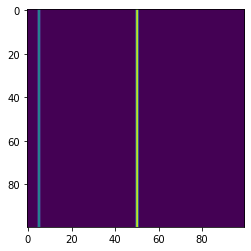

In [ ]:
target = torch.zeros(100,100)
target[:,5] = 1
target[:,50] = 2
plt.imshow(target);

Nearly everything is background in this example, and we have a thin river at the left of the image as well as a thin road in the middle of the image. If all our data looks similar to this, we say that there is a class imbalance, meaning that some classes (like river and road) appear relatively infrequently. If our model just predicted "background" (i.e. the value 0) for all pixels, it would be correct for most pixels. But this would be a bad model and the diceloss should reflect that

In [ ]:
model_output_all_background = torch.zeros(3, 100,100)
# assign probability 1 to class 0 everywhere
model_output_all_background[0,:,:] = 1 

In [ ]:
# add a batch dimension
model_output_all_background = torch.unsqueeze(model_output_all_background,0)
target = torch.unsqueeze(target,0)

Our dice score should be around 1/3 here, because the "background" class is predicted correctly (and that for nearly every pixel), but the other two clases are never predicted correctly. Dice score of 1/3 means dice loss of 1 - 1/3 = 2/3:

In [ ]:
dl(model_output_all_background, target)

tensor(0.6634)

In [ ]:
test_close(dl(model_output_all_background, target), 0.67, eps=0.01)

If the model would predict everything correctly, the dice loss should be zero:

In [ ]:
correct_model_output = torch.zeros(3, 100,100)
correct_model_output[0,:,:] = 1 
correct_model_output[0,:,5] = 0 
correct_model_output[0,:,50] = 0
correct_model_output[1,:,5] = 1 
correct_model_output[2,:,50] = 1 
correct_model_output = torch.unsqueeze(correct_model_output, 0)

In [ ]:
dl(correct_model_output, target)

tensor(0.)

In [ ]:
test_close(dl(correct_model_output, target), 0)

And finally the dice loss should be close to 1 if the model output is random:

In [ ]:
dl(torch.randn(1,3,100,100), target)

tensor(1.0056)

In [ ]:
test_close(dl(torch.randn(1,3,100,100), target), 1.0, eps = 0.1)

In summary, the dice loss is 1 for random input, approximately 0.67 for guessing that everything is background and 0 if we perfectly predict everything. Let us compare this to how the CrossEntropyLoss works for this example

In [ ]:
celf = CrossEntropyLossFlat(axis=1)

In [ ]:
celf(correct_model_output, target.int())

TensorBase(0.5514)

In [ ]:
celf(model_output_all_background, target.int())

TensorBase(0.5714)

In [ ]:
celf(torch.randn(1,3,100,100), target.int())

TensorBase(1.3901)

As you can see, the cross entropy loss does not strongly distinguish between the correct model output and the one where everything is classified as background. This is why the dice loss is more suitable in scenarions with class imbalance.

In [ ]:
#hide
#cuda
#Test DicceLoss work in half precision
if torch.cuda.is_available():
    output = torch.randn(32, 4, 5, 10).half().cuda()
    target = torch.randint(0,2,(32, 5, 10)).half().cuda()
    _ = dl(output, target)

You could easily combine this loss with `FocalLoss` defining a `CombinedLoss`, to balance between global (Dice) and local (Focal) features on the target mask.

In [ ]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
cl = CombinedLoss()
output = torch.randn(32, 4, 5, 10)
target = torch.randint(0,2,(32, 5, 10))
_ = cl(output, target)

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 